In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from LAB_UW_functions import *
from scipy.signal import find_peaks
import glob

### This code allows you to plot a specific part of the experiment (mechanical data) over the waveforms recorded in that interval through a amplitude map ###

In [2]:
def find_mechanical_data(file_path_list, pattern):
    """
    Trova un file specifico all'interno di una lista di percorsi dei file utilizzando un pattern.
    
    Args:
        file_path_list (list): Lista di percorsi dei file in cui cercare il file.
        pattern (str): Pattern per il nome del file da cercare.
    
    Returns:
        str: Percorso completo del file trovato, o None se non viene trovato nessun file corrispondente.
    """
    for file_path in file_path_list:
        if glob.fnmatch.fnmatch(file_path, pattern):
            print("MECHANICAL DATA CHOOSE:", file_path)
            return file_path
    return None  # Nessun file trovato nella lista
    

def find_sync_values(mech_data_path):
    """
    Trova i valori di picco sincronizzazione all'interno di un file di dati meccanici.

    Questa funzione legge un file CSV contenente dati meccanici, estrae la colonna
    relativa alla sincronizzazione e individua i picchi di sincronizzazione in base
    ai parametri specificati.

    Args:
        mech_data_path (str): Percorso del file CSV contenente i dati meccanici.

    Returns:
        numpy.ndarray: Un array NumPy contenente gli indici dei picchi di sincronizzazione
                       trovati nei dati meccanici.
    """
    mech_data = pd.read_csv(mech_data_path, sep='\t', skiprows=[1])
    sync_data = mech_data.sync
    
    # Trova i picchi di sincronizzazione nei dati sincronizzazione
    sync_peaks, _ = find_peaks(sync_data, prominence=0.4, height=0.4)
    print(sync_peaks)
    return mech_data, sync_data, sync_peaks

def plot_sync_peaks(sync_data, sync_peaks, experiment_name):
    """
    Visualizza i picchi di sincronizzazione su un grafico dei dati di sincronizzazione.

    Questa funzione prende i dati di sincronizzazione e gli indici dei picchi di sincronizzazione,
    quindi crea un grafico per visualizzare sia i dati di sincronizzazione che i picchi di sincronizzazione
    evidenziati in rosso.

    Args:
        sync_data (numpy.ndarray): Array NumPy contenente i dati di sincronizzazione.
        sync_peaks (numpy.ndarray): Array NumPy contenente gli indici dei picchi di sincronizzazione.
        experiment_name (str): Nome dell'esperimento o della prova da visualizzare nel titolo del grafico.
    """
    %matplotlib inline
    
    plt.figure(figsize=(10, 4))
    plt.title(f'Sync Peaks {experiment_name}')
    

    # Plot dei picchi di sincronizzazione evidenziati in rosso
    plt.scatter(np.arange(0, len(sync_data))[sync_peaks], sync_data[sync_peaks], c='r', s = 10, zorder = 2, alpha = 0.8)
    
    # Plot dei dati di sincronizzazione
    plt.plot(sync_data, zorder = 1, c = 'k', linewidth = 0.8)
    
    plt.ylabel('Arduino voltage [V]', fontsize=12)
    plt.xlabel('records #', fontsize=12)
    
    plt.show()

### Set parameters ###

In [3]:
machine_name = 'Brava_2'   #machine name
experiment_name = 's0112'   #experiment name
data_type_mech = 'mechanical_data'  #choose data type
sync_file_pattern = '*s*_data_rp' #pattern to find specific experiment in mechanical data
uw_file_number = 5     #choose number of eaveform file

data_type_uw = 'data_tsv_files'   #choose data type
remove_initial_samples = 50    #remove initial samples of the wf to cut thje initial noise

#MAKE MECHANICAL AND UW PATH LIST
infile_path_list_mech = make_infile_path_list(machine_name, experiment_name, data_type=data_type_mech)   #make a list of the files inside mechanical data
infile_path_list_uw = sorted(make_infile_path_list(machine_name,experiment_name, data_type=data_type_uw))  #make a list of the wf files

#LOAD MECHANICAL DATA
mech_data_path= find_mechanical_data(infile_path_list_mech, sync_file_pattern)   #find the path of the experiment selected


uw_path = infile_path_list_uw[uw_file_number]
uw_path

MECHANICAL DATA CHOOSE: c:\Users\miche\Documents\Università\PhD\ACTIVE_SOURCE\experiments_Brava_2\s0112\mechanical_data\s0112sa05ato_204060_data_rp


'c:\\Users\\miche\\Documents\\Università\\PhD\\ACTIVE_SOURCE\\experiments_Brava_2\\s0112\\data_tsv_files\\007_step_3_30_3_40MPa.bscan.tsv'

### Import mechanical and acoustic data ###

[  6148   7848   9297  22904  27503  40128  51238 114608 122192 123707
 125435 139123 143745 156318 168122 227608 232676 234123 235982 237682
 239423 253077 257696 270171 290158 362818]


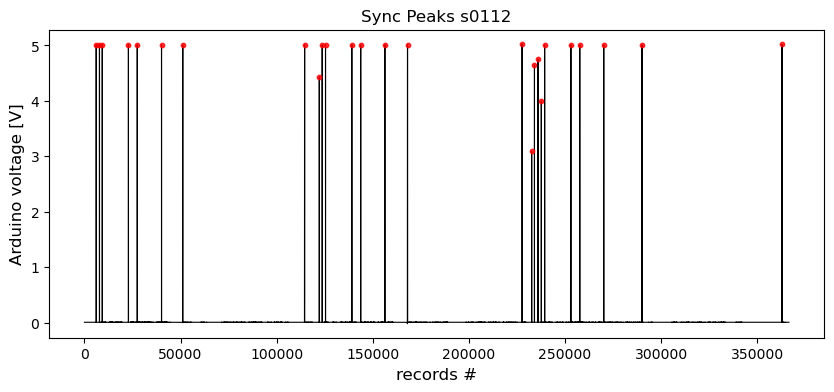

In [4]:
mech_data, sync_data, sync_peaks = find_sync_values(mech_data_path) #import mechanical data and check peak values
plot_sync_peaks(sync_data, sync_peaks, experiment_name)  #plot sync peaks, if you have some missing peaks fix the prominence and height in the function plot_sync_peaks

### Import and extract metadata from waveforms files ###

In [5]:
data_uw, metadata_uw = make_UW_data(uw_path)  #import acoustic data
time_ax_waveform = metadata_uw['time_ax_waveform']
start_time, end_time = time_ax_waveform[0], time_ax_waveform[-1]
sampling_rate = metadata_uw['sampling_rate']
number_of_samples = metadata_uw['number_of_samples']
acquisition_frequency =  metadata_uw['acquition_frequency']
amp_scale = 100

### Initialize parameters, calculate maximum and minimum travel time for the amplitude map ###

In [6]:
side_block_1 = 2               # [cm] width of first side block
side_block_2 =2               # [cm] width of first gouge layer
central_block = 4.8
pzt_width = 0.1                                 # [cm] its important!
pla_width = 0.1                                 # [cm] plate supporting the pzt
csteel = 3250 * (1e2/1e6)       # [cm/mus]   steel s-velocity
cpzt = 2000* (1e2/1e6)         # [cm/mus] s-velocity in piezo ceramic, beetween 1600 (bad coupling) and 2500 (good one). It matters!!!
                                # according to https://www.intechopen.com/chapters/40134   
cpla =  0.2*0.1392              # [cm/mus]   plate supporting the pzt

x_trasmitter = 1    # [cm] position of the trasmitter from the beginning of the sample: the distance from the beginning of the block is fixed.

cmin = 1000 * (1e2/1e6)        
cmax = 2000 * (1e2/1e6)

thickness_gouge_1 = mech_data.rgt_lt_mm[sync_peaks[uw_file_number*2]]/10

max_wf_time = 2*(side_block_1-x_trasmitter)/csteel + thickness_gouge_1/cmin+ central_block/csteel + thickness_gouge_1/cmin 
min_wf_time = 2*(side_block_1-x_trasmitter)/csteel + thickness_gouge_1/cmax+ central_block/csteel + thickness_gouge_1/cmax

time_plot = mech_data.time_s[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]]  #index time between sync peaks
time_plot = time_plot - time_plot[sync_peaks[uw_file_number*2]]
friction_plot = mech_data.friction_na[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]]  #index friction between sync peaks
displacement_plot = mech_data.lp_disp_mm[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]]  #index displacement between sync peaks

#calculate minimum and maximum friction in the interval to normalize it and obtain a correct visualization on the amplitude map
min_friction = np.min(friction_plot)  
max_friction = np.max(friction_plot)

# Normalize friction to wf time values to obtain a good visualization of the data over the amp map
friction_scaled = ((friction_plot - min_friction) / (max_friction - min_friction)) * (max_wf_time - min_wf_time) + min_wf_time

## Plot mechanical data on the amplitude map ##

In [21]:
%matplotlib qt

fig,ax1 = plt.subplots(ncols = 1,figsize=(19,8))
ax1 = plt.subplot()
ax1.set_title("Waveforms Amplitude map VS Friction data" , fontsize = 18)
cmap = plt.get_cmap('seismic')

ax1.plot(time_plot, friction_scaled, linewidth = 1.5, c = 'k')
im = ax1.imshow(data_uw.T, aspect='auto',origin='lower',interpolation='none',
                cmap = cmap, vmin = -amp_scale, vmax = amp_scale,
                extent = [0,time_plot.iloc[-1], 0 , number_of_samples*sampling_rate])

cbar= fig.colorbar(im,pad=0.04)
cbar.set_label("Relative Amplitude [a.u.]", fontsize = 16)
ax1.set_xlabel('Time [s]', fontsize = 16)
ax1.set_ylabel('Wf_time [$\mu s$] ', fontsize = 16)
ax1.set_xscale
ax1.set_ylim(min_wf_time-3, max_wf_time+3)
ax1.tick_params(axis='x', labelsize=14)  
ax1.tick_params(axis='y', labelsize=14)
cbar.ax.tick_params(labelsize=14)
#fig.tight_layout()

#plt.savefig('amplitudemap_on_vstep_mont.pdf', dpi = 300)